# <span style="color:MistyRose">**Baseline ML Model**</span>
RandomForestRegressor used to predict Cetane Number and YSI

## <span style="color:IndianRed">1. Initialisation</span>
### 1.1 Importing Libraries and Datasets

In [10]:
import sqlite3
import pandas as pd
import numpy as np
from collections import Counter
import re
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdFingerprintGenerator
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
import os
warnings.filterwarnings("ignore")
# Get the folder where the notebook is running
BASE_DIR = os.path.dirname(os.getcwd())  # go up one directory


DB_PATH = os.path.join(BASE_DIR, "data", "database", "latest_fuel_database.db")
CANDIDATE_CSV = os.path.join(BASE_DIR, "data", "raw", "candidates_3.csv")

TARGET_CN = "cn"      # Cetane number
TARGET_YSI = "ysi"    # Soot proxy
N_FOLDS = 5
TOP_K = 5

In [11]:
print("Connecting to SQLite database...")
conn = sqlite3.connect(DB_PATH)

query = """
SELECT 
    F.Fuel_Name,
    F.SMILES,
    F.SI_Melting_Point, F.EX_Melting_Point,
    F.SI_Boiling_Point, F.EX_Boiling_Point,
    F.SI_Enthalpy_of_Vaporization, F.EX_Enthalpy_of_Vaporization,
    F.SI_Surface_Tension, F.EX_Surface_Tension,
    F.SI_Dynamic_Viscosity, F.EX_Dynamic_Viscosity,
    F.SI_Lower_Heating_Value, F.EX_Lower_Heating_Value,
    F.SI_Liquid_Density, F.EX_Liquid_Density,
    T.Standardised_YSI AS ysi,
    T.Standardised_DCN AS cn
FROM FUEL F
LEFT JOIN TARGET T ON F.fuel_id = T.fuel_id
"""
df = pd.read_sql_query(query, conn)


conn.close()

print(df.head())
print(df.columns)

Connecting to SQLite database...
                     Fuel_Name                SMILES  SI_Melting_Point  \
0                     geraniol  CC(C)=CCC\C(\C)=C\CO               NaN   
1  (1,1-dimethylethyl)-benzene      CC(C)(C)c1ccccc1         -104.1570   
2          (1-butynyl)-benzene         CCC#Cc1ccccc1               NaN   
3    (1-methylethenyl)-benzene        C=C(C)c1ccccc1               NaN   
4     (1-methylpropyl)-benzene        CCC(C)c1ccccc1          -90.4875   

   EX_Melting_Point  SI_Boiling_Point  EX_Boiling_Point  \
0               NaN               NaN               NaN   
1               NaN          179.0027               NaN   
2               NaN               NaN               NaN   
3               NaN               NaN               NaN   
4               NaN          174.0441               NaN   

   SI_Enthalpy_of_Vaporization  EX_Enthalpy_of_Vaporization  \
0                          NaN                          NaN   
1                     49.70751           

## Training the Model

Uses a Random Forest Regressor to train for two targets: Cetane Number (CN) and Yield Sooting Index (YSI). 

In [16]:

# ---------- Helper functions ----------
def safe_mol(smiles):
    if pd.isna(smiles): return None
    try:
        return Chem.MolFromSmiles(str(smiles).strip())
    except:
        return None

def featurize_mol(mol, nBits=512):
    row = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol)
    }
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=nBits)
    fp = fpgen.GetFingerprint(mol)
    arr = np.array(list(fp.ToBitString()), dtype=int)
    for i, b in enumerate(arr):
        row[f"fp_{i}"] = int(b)
    return row

def build_feature_df(df, smiles_col):
    feats = []
    idxs = []
    for i, r in df.iterrows():
        mol = safe_mol(r[smiles_col])
        if mol is None:
            continue
        feats.append(featurize_mol(mol))
        idxs.append(i)
    feat_df = pd.DataFrame(feats, index=idxs)
    return feat_df


def diesel_constraints(fuel_type, predictions, strict=True):
    if fuel_type == "biodiesel":
        constraints = {
            'CN': (51, max(df['cn'])),  # min,max
            'density_15C': (860,900),  # kg/m³
            'viscosity_40C': (3.5, 5.0),  # mm²/s
            'boiling_point': (240, 360),  # °C
            
        }
    elif fuel_type == "paraffinic":
        constraints = {
            'CN': (70, max(df['cn'])),
            'density_15C': (770, 800),
            'viscosity_40C': (2, 4.5),
            'boiling_point': (180, 360),
            
        }
    else:
        constraints = {
            'CN': (51, max(df['cn'])),
            'density_15C': (820, 845),
            'viscosity_40C': (2, 4.5),
            'boiling_point': (180, 360),
            
        }
    passes = {}
    for prop, (min_val, max_val) in constraints.items():
        if prop in predictions:
            value = predictions[prop]
            passes[prop] = (min_val <= value <= max_val)
        else:
            passes[prop] = None if strict else True  # Handle missing predictions
    
    # Overall pass: all constraints met
    meets_specs = all(v for v in passes.values() if v is not None)
    
    return meets_specs, passes



def train_and_eval(X, y):
    if X is None or y is None or len(y) < 10:
        return None, None, None
    
    # Remove any remaining NaN values
    mask = ~np.isnan(y)
    X_clean = X[mask]
    y_clean = y[mask]
    
    # Check if we still have enough data
    if len(y_clean) < 10:
        print(f"Warning: Only {len(y_clean)} valid samples after NaN removal")
        return None, None, None
    
    model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    n_splits = min(N_FOLDS, len(y_clean)//3)
    if n_splits < 2:
        n_splits = 2
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_clean, y_clean, cv=cv, scoring='r2')
    model.fit(X_clean, y_clean)
    return model, scores.mean(), scores.std()

# ---------- Load and preprocess ----------

# Clean numeric columns
for col in [TARGET_CN, TARGET_YSI]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# ---------- Build feature set ----------
print("Featurizing training molecules...")
Xdesc = build_feature_df(df, smiles_col="SMILES")
meta = df.loc[Xdesc.index]

# CN dataset
cn_mask = meta[TARGET_CN].notna()
if cn_mask.sum() > 5:
    X_cn = Xdesc.loc[cn_mask]
    y_cn = meta.loc[cn_mask, TARGET_CN].values
    print(f"CN data: {len(y_cn)} samples")
else:
    X_cn, y_cn = None, None
    print("No CN data available.")

# YSI dataset (soot proxy)
ysi_mask = meta[TARGET_YSI].notna()
if ysi_mask.sum() > 5:
    X_ysi = Xdesc.loc[ysi_mask]
    y_ysi_raw = meta.loc[ysi_mask, TARGET_YSI].values
    
    # Check for negative or zero values before log transform
    if (y_ysi_raw <= 0).any():
        print(f"Warning: {np.sum(y_ysi_raw <= 0)} YSI values are <= 0. Adding small constant.")
        y_ysi_raw = y_ysi_raw + 1e-6  # Add small constant to avoid log(0)
    
    y_ysi = np.log1p(y_ysi_raw)
    print(f"YSI data: {len(y_ysi)} samples")
else:
    X_ysi, y_ysi = None, None
    print("No YSI data available.")

# ---------- Train models ----------
if X_cn is not None and y_cn is not None:
    model_cn, mean_cn, std_cn = train_and_eval(X_cn, y_cn)
    if model_cn is not None:
        print(f"CN model: R² = {mean_cn:.3f} ± {std_cn:.3f}")
    else:
        model_cn = None
        print("CN model training failed - not enough valid data")
else:
    model_cn = None

if X_ysi is not None and y_ysi is not None:
    model_ysi, mean_ysi, std_ysi = train_and_eval(X_ysi, y_ysi)
    if model_ysi is not None:
        print(f"YSI model: R² = {mean_ysi:.3f} ± {std_ysi:.3f}")
    else:
        model_ysi = None
        print("YSI model training failed - not enough valid data")
else:
    model_ysi = None


Featurizing training molecules...
CN data: 1233 samples
YSI data: 1361 samples
CN model: R² = 0.768 ± 0.052
YSI model: R² = 0.944 ± 0.015


# Candidate Fuel Optimisation and Selection

In [14]:

# ---------- Predict on candidates ----------
print("Loading candidate molecules...")
candidates = pd.read_csv(CANDIDATE_CSV, encoding="latin1")
candidates.rename(columns=lambda x: x.strip().lower(), inplace=True)
candidates['smiles'] = candidates['smiles'].astype(str).str.replace(r'[\r\n]+', '', regex=True).str.strip()

print(f"Candidate columns: {candidates.columns.tolist()}")
print(f"Candidate shape: {candidates.shape}")

cand_feat = build_feature_df(candidates, smiles_col="smiles")
print(f"Successfully featurized {len(cand_feat)} candidate molecules")

preds = pd.DataFrame(index=cand_feat.index)
if model_cn is not None:
    preds["CN_pred"] = model_cn.predict(cand_feat)
if model_ysi is not None:
    preds["YSI_log_pred"] = model_ysi.predict(cand_feat)
    preds["YSI_pred"] = np.expm1(preds["YSI_log_pred"])

combined = candidates.loc[cand_feat.index].join(preds)
print(f"Combined data shape: {combined.shape}")

# ---------- Objective selection ----------
print("\nAvailable objectives:")
available_cols = combined.columns.tolist()
print(f"Available columns: {available_cols}")

if model_cn is not None:
    print("1. Maximise Cetane Number (CN)")
    print("2. Maximise CN within range (min,max)")
if model_ysi is not None:
    print("3. Minimise Soot proxy (YSI)")
if model_cn is not None and model_ysi is not None:
    print("4. Multi-objective: maximise CN and minimise YSI")

choice = input("Choose objective (1–4): ").strip()

# Create results directory if it doesn't exist
os.makedirs("results", exist_ok=True)

# Determine which columns to display
display_cols = ["smiles", "CN_pred", "YSI_pred"]
# Check if 'name' column exists, if not use the first column that's not smiles
if "name" in combined.columns:
    display_cols.insert(0, "name")
else:
    # Use the first non-smiles column as identifier
    other_cols = [col for col in combined.columns if col != "smiles" and not col.endswith("_pred")]
    if other_cols:
        display_cols.insert(0, other_cols[0])

if choice == "1" and "CN_pred" in combined.columns:
    out = combined.sort_values("CN_pred", ascending=False).head(TOP_K)
elif choice == "2" and "CN_pred" in combined.columns:
    lo = float(input("Min CN: "))
    hi = float(input("Max CN: "))
    filt = combined.query("@lo <= CN_pred <= @hi")
    out = filt.sort_values("CN_pred", ascending=False).head(TOP_K)
elif choice == "3" and "YSI_pred" in combined.columns:
    out = combined.sort_values("YSI_pred", ascending=True).head(TOP_K)
elif choice == "4" and {"CN_pred", "YSI_pred"} <= set(combined.columns):
    w = float(input("Weight for CN (0–1): "))
    cn_norm = (combined["CN_pred"] - combined["CN_pred"].min()) / (combined["CN_pred"].max() - combined["CN_pred"].min())
    ysi_norm = (combined["YSI_pred"] - combined["YSI_pred"].min()) / (combined["YSI_pred"].max() - combined["YSI_pred"].min())
    combined["score"] = w * cn_norm + (1 - w) * (1 - ysi_norm)
    out = combined.sort_values("score", ascending=False).head(TOP_K)
else:
    raise SystemExit("Objective not available or missing required predictions.")

# ---------- Output ----------
print("\nTop candidates:")
# Only display columns that actually exist
final_display_cols = [col for col in display_cols if col in out.columns]
print(out[final_display_cols].to_string(index=False))

out.to_csv("results/top_candidates.csv", index=False)
print("\nSaved top candidates to results/top_candidates.csv")

Loading candidate molecules...
Candidate columns: ['names', 'smiles']
Candidate shape: (271, 2)
Successfully featurized 271 candidate molecules
Combined data shape: (271, 5)

Available objectives:
Available columns: ['names', 'smiles', 'CN_pred', 'YSI_log_pred', 'YSI_pred']
1. Maximise Cetane Number (CN)
2. Maximise CN within range (min,max)
3. Minimise Soot proxy (YSI)
4. Multi-objective: maximise CN and minimise YSI

Top candidates:
                          names                          smiles   CN_pred   YSI_pred
                    Heptadecane               CCCCCCCCCCCCCCCCC 96.465651 112.649206
                2-Heptacosanone CCCCCCCCCCCCCCCCCCCCCCCCCC(=O)C 92.954908 204.504308
                     Hexadecane                CCCCCCCCCCCCCCCC 92.083598 105.912447
Octadecanoic acid, methyl ester        CCCCCCCCCCCCCCCCCC(=O)OC 91.301957 129.865293
                    Pentadecane                 CCCCCCCCCCCCCCC 91.262685 101.623794

Saved top candidates to results/top_candidates.csv

## Data Analysis

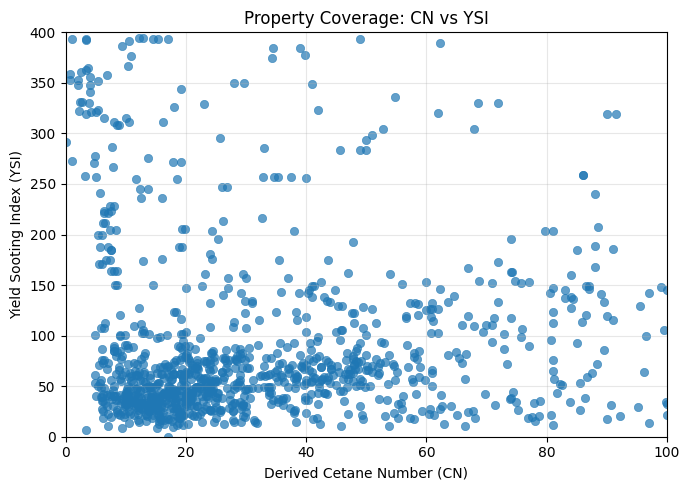

In [4]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["SMILES"])  # keep valid SMILES

plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="cn", y="ysi", alpha=0.7, edgecolor=None)
plt.xlabel("Derived Cetane Number (CN)")
plt.xlim(0, 100)
plt.ylim(0,400)
plt.ylabel("Yield Sooting Index (YSI)")
plt.title("Property Coverage: CN vs YSI")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:

def count_smiles_classes(smiles_list):
    """
    Count the number of alkanes, alkenes, aromatics, and oxygenates from a list of SMILES strings.
    
    Parameters:
    smiles_list (list): List of SMILES strings
    
    Returns:
    dict: Dictionary with counts for each compound class
    """
    
    # Initialize counters
    counts = {
        'alkanes': 0,
        'alkenes': 0, 
        'aromatics': 0,
        'oxygenates': 0,
        'total_processed': 0,
        'invalid_smiles': 0
    }
    
    for smiles in smiles_list:
        try:
            # Create molecule from SMILES
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                counts['invalid_smiles'] += 1
                continue
                
            counts['total_processed'] += 1
            
            # Check for aromatic rings
            aromatic_rings = False
            if mol.GetRingInfo().NumRings() > 0:
                # Check if any ring is aromatic
                for ring in mol.GetRingInfo().AtomRings():
                    if any(mol.GetAtomWithIdx(atom).GetIsAromatic() for atom in ring):
                        aromatic_rings = True
                        break
            
            # Check for double bonds (alkenes)
            has_double_bonds = any(bond.GetBondType() == Chem.BondType.DOUBLE 
                                 for bond in mol.GetBonds())
            
            # Check for oxygen atoms (oxygenates)
            has_oxygen = any(atom.GetSymbol() == 'O' for atom in mol.GetAtoms())
            
            # Classification logic
            if aromatic_rings:
                counts['aromatics'] += 1
            elif has_double_bonds:
                counts['alkenes'] += 1
            elif not has_double_bonds and not aromatic_rings:
                # Check if it's purely hydrocarbon (only C and H)
                elements = set(atom.GetSymbol() for atom in mol.GetAtoms())
                if elements.issubset({'C', 'H'}):
                    counts['alkanes'] += 1
            
            # Oxygenates (can overlap with other categories)
            if has_oxygen:
                counts['oxygenates'] += 1
                
        except Exception as e:
            counts['invalid_smiles'] += 1
            print(f"Error processing SMILES '{smiles}': {e}")
    
    return counts

# Example usage:
if __name__ == "__main__":
    
    results = count_smiles_classes(df['SMILES'])
    
    print("SMILES Classification Results:")
    print(f"Total processed: {results['total_processed']}")
    print(f"Invalid SMILES: {results['invalid_smiles']}")
    print(f"Alkanes: {results['alkanes']}")
    print(f"Alkenes: {results['alkenes']}")
    print(f"Aromatics: {results['aromatics']}")
    print(f"Oxygenates: {results['oxygenates']}")



SMILES Classification Results:
Total processed: 1493
Invalid SMILES: 0
Alkanes: 248
Alkenes: 708
Aromatics: 336
Oxygenates: 779


## Learning Curve

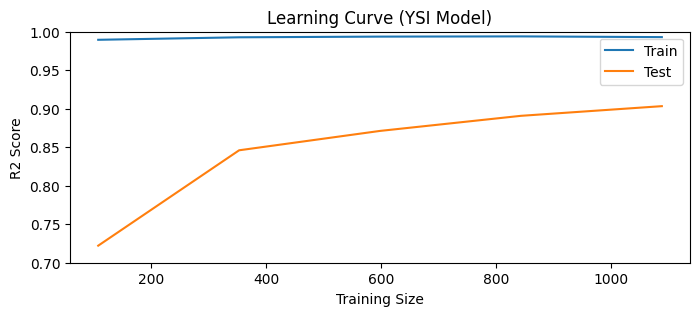

(<matplotlib.legend.Legend at 0x199aeee9810>, None)

In [31]:
train_sizes, train_scores, test_scores = learning_curve(model_ysi, X_ysi, y_ysi, cv=5)
plt.figure(figsize=(8,3))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.title('Learning Curve (YSI Model)')
plt.xlabel('Training Size')
plt.ylabel('R2 Score')
plt.ylim(0.7,1)
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.legend(), plt.show()

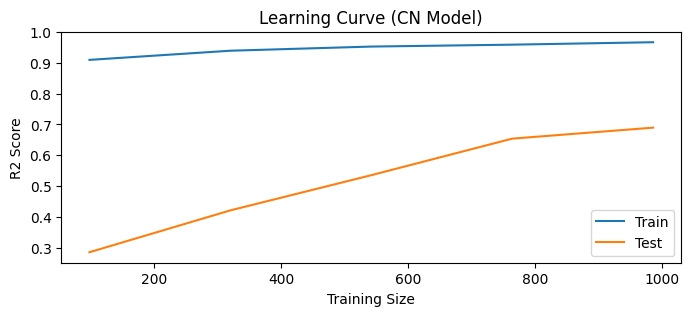

(<matplotlib.legend.Legend at 0x199adf5b7c0>, None)

In [30]:
train_sizes, train_scores, test_scores = learning_curve(model_cn, X_cn, y_cn, cv=5)
plt.figure(figsize=(8,3))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.title('Learning Curve (CN Model)')
plt.xlabel('Training Size')
plt.ylabel('R2 Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test')
plt.legend(), plt.show()